## Fyve By Technical Interview

Before you begin, please read the full assignment.

A few comments::
- Use any external libraries you wish; however, you must explain why you used each. Recommended solution should not need anything outside numpy, open3D, scipy, and matplotlib.
- Comments on the code would be appreciated (on the why and not on what)
- We value clean, high performance code, written with proper error handling and integration in mind.
- If it helps (suggested for debugging purposes) you are free to add cells to plot the results of your functions. This is absolutely NOT mandatory, but it would show your understanding of visualization tools (something that will be an integral part of your work as a Computer Vision engineer).

Python 3.10 (Recommended)

# Problem Statement

You are responsible for identifying and tracking an airplane moving through a 3D space. You are provided with a sequence of fused pointclouds (from 4 LiDAR sensors) where each pointcloud frame contains the airplane in a different position. Your task is to track a consistent point on the airplane across time. Hint: There is a reason we gave you multiple frames. 

You should:
1. Write Pseudocode that outlines your tracking approach 
2. State any assumptions you make about the data or problem
3. Implement funtions you would use to process and extract the tracking point
4. Answer all follow-up questions

Inputs: 
- Fused pointcloud (from 4 lidar) that contains an airplane moving in 3D space. 

Expected Outputs:
- Tracking point (x,y,z) of airplane (this can be any point on the plane; however it should be consistent. While not expected, think about how you could find the orientation of the airplane.)

*This should be a simple solution, there is no need to implement any fancy state estimation algorithms.*

In [1]:
import glob
import os
import open3d as o3d
#import open3d.visualization.plotly as o3d_plotly
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def preprocess_point_cloud(input_pcd):
    """Removes outliers and downsamples point cloud for faster processing.
    Args: input_pcd: open3d.geometry.PointCloud
    Returns: open3d.geometry.PointCloud (downsampled and filtered point cloud)
    """
    
    cl, ind = input_pcd.remove_statistical_outlier(nb_neighbors=10, std_ratio=2.75)
    filtered_pcd = input_pcd.select_by_index(ind)
    down_pcd = filtered_pcd.voxel_down_sample(voxel_size=0.005)
    return down_pcd


def cluster_point_cloud(input_pcd):
    """Segments above-ground clusters and filters airplane like clusters. Using DBSCAN clustering and geometric heuristics to identify clusters within the filtered points. 
    Then evaluates each cluster to check if the geometric properties match those of an airplane.
    Args: input_pcd: open3d.geometry.PointCloud
    Returns: Candidates : open3d.geometry.PointCloud of the airplane like cluster or None
    """
    points = np.asarray(input_pcd.points)
    if len(points) == 0:
        return None

    # Filter points above ground level (5th percentile + small margin)
    z_values = points[:, 2]
    height_threshold = np.percentile(z_values, 5)
    above_ground_indices = np.where(z_values > height_threshold + 0.1)[0]
    if len(above_ground_indices) == 0:
        return None

    # Cluster the above ground points
    above_ground_pcd = input_pcd.select_by_index(above_ground_indices)
    
    # DBSCAN clustering
    labels = np.array(above_ground_pcd.cluster_dbscan(eps=0.9, min_points=10, print_progress=False))
    if labels.max() < 0:
        return None
    
    
    #Loop over each cluster and check if it matches airplane like geometry
    def is_airplane_like(pcd):
        if len(pcd.points) < 200:
            return False
        bbox = pcd.get_axis_aligned_bounding_box()
        extent = bbox.get_extent()
        length, width, height = sorted(extent, reverse=True)
        aspect_ratio = length / max(width, 1e-3)
        return height < 4.5 and width > 4.0 and length > 6.0 and aspect_ratio > 1.277

    # Selects the largest airline like cluster based on number of sorted points
    candidates = []
    for cluster_id in np.unique(labels[labels >= 0]):
        indices = np.where(labels == cluster_id)[0]
        cluster = above_ground_pcd.select_by_index(indices)
        if is_airplane_like(cluster):
            candidates.append((len(indices), cluster))

    if not candidates:
        return None

    candidates.sort(reverse=True)
    return candidates[0][1]


def extract_tracking_point(clustered_pcd, prev_axis=None):
    """Extracts tail point and principal orientation from airplane cluster.
    Args: Input : clustered_pcd: open3d.geometry.PointCloud
                  prev_axis: numpy array of previous frame's primary axis (for orientation consistency)
          Output : tail_point: numpy array of 3D point (tail point), centroid: numpy array of 3D point (centroid of cluster), orientation: numpy array of 3x3 matrix (principal axes), prev_axis: numpy array of primary axis for next frame"""
    
    # Compute PCA to find principal axes
    points = np.asarray(clustered_pcd.points)
    if len(points) < 3:
        return None, None, None, prev_axis

    # Compute the centroid of the cluster and perform PCA via covariance matrix. Eigenvectors represent principle direction and eigenvalues gives the variance along those directions.
    centroid = np.mean(points, axis=0)
    centered = points - centroid
    cov = np.cov(centered, rowvar=False)
    eig_vals, eig_vecs = np.linalg.eigh(cov)
    eig_vecs = eig_vecs[:, np.argsort(eig_vals)[::-1]]

    # Flip primary axis to maintain orientation consistency
    if prev_axis is not None and np.dot(eig_vecs[:, 0], prev_axis) < 0:
        eig_vecs[:, 0] *= -1

    # Project points on the priciple direction and select the top most 5% points to represent the tail point
    projections = np.dot(centered, eig_vecs[:, 0])
    threshold = np.percentile(projections, 95)
    tail_indices = np.where(projections >= threshold)[0]
    if len(tail_indices) == 0:
        return None, centroid, eig_vecs, eig_vecs[:, 0]

    tail_point = np.mean(points[tail_indices], axis=0)
    return tail_point, centroid, eig_vecs, eig_vecs[:, 0]


def plot_tail_trajectory(tracking_points):
    """Plots 2D and 3D tail trajectory. The tail point is considered as the tracking point as I found that the region was very well visible in the point cloud data constantly across all the frames and in this scenario as that part was the first to enter the hangar space, tracking a point using that portion was a safe bet.
    Args: Input : tracking_points: List of 3D points (numpy arrays)
    Output : Trajectory plots in 2D and 3D"""
    
    tail_array = np.array(tracking_points)

    # 2D Plot
    plt.figure(figsize=(8, 6))
    plt.plot(tail_array[:, 0], tail_array[:, 1], 'o-', color='blue', label="Tail Trajectory")
    plt.scatter(tail_array[0, 0], tail_array[0, 1], color='green', label="Start", s=100, marker='^')
    plt.scatter(tail_array[-1, 0], tail_array[-1, 1], color='red', label="End", s=100, marker='x')
    plt.title("Tail Trajectory (XY)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()

    # 3D Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(tail_array[:, 0], tail_array[:, 1], tail_array[:, 2], 'o-', color='purple', label="Tail Trajectory")
    ax.scatter(tail_array[0, 0], tail_array[0, 1], tail_array[0, 2], color='green', label="Start", s=100, marker='^')
    ax.scatter(tail_array[-1, 0], tail_array[-1, 1], tail_array[-1, 2], color='red', label="End", s=100, marker='x')
    ax.set_title("Tail Trajectory (3D)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    ax.grid(True)

    # Set the Scale equal to the Point Cloud Scale
    ranges = np.ptp(tail_array, axis=0)
    max_range = max(ranges)
    centers = np.mean(tail_array, axis=0)
    ax.set_xlim(centers[0] - max_range / 2, centers[0] + max_range / 2)
    ax.set_ylim(centers[1] - max_range / 2, centers[1] + max_range / 2)
    ax.set_zlim(centers[2] - max_range / 2, centers[2] + max_range / 2)

    plt.show()

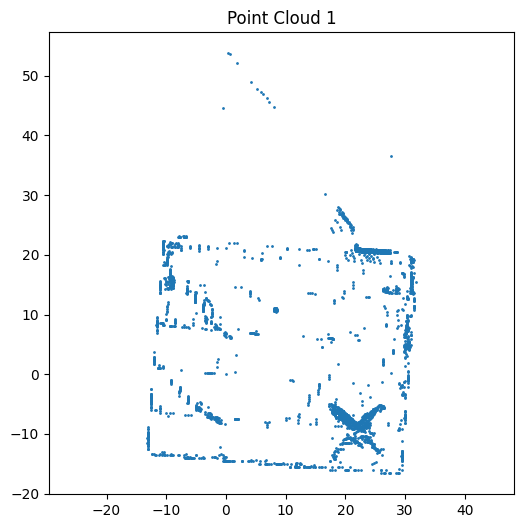


[Frame 1] frame_1.ply
  No airplane cluster detected.


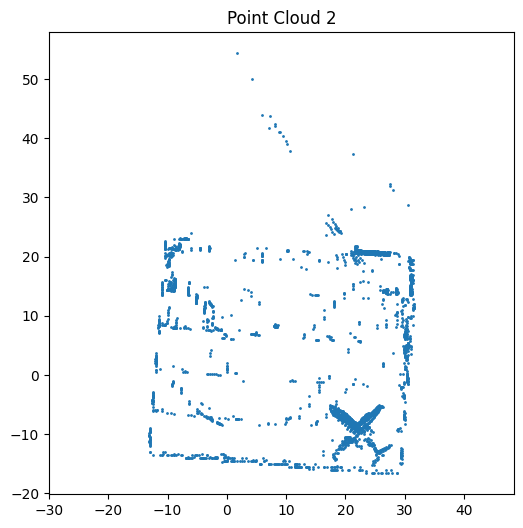


[Frame 2] frame_2.ply
  No airplane cluster detected.


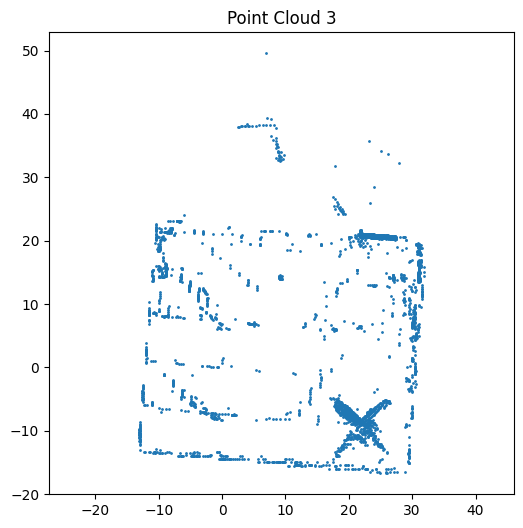


[Frame 3] frame_3.ply
  Tail Point: [22.42801866 20.66148786 -1.16654329]


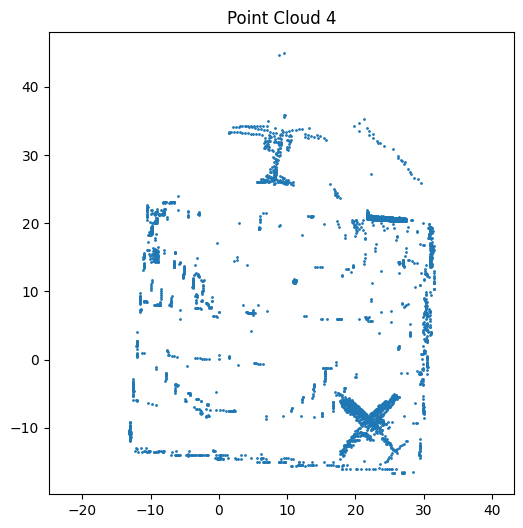


[Frame 4] frame_4.ply
  No airplane cluster detected.


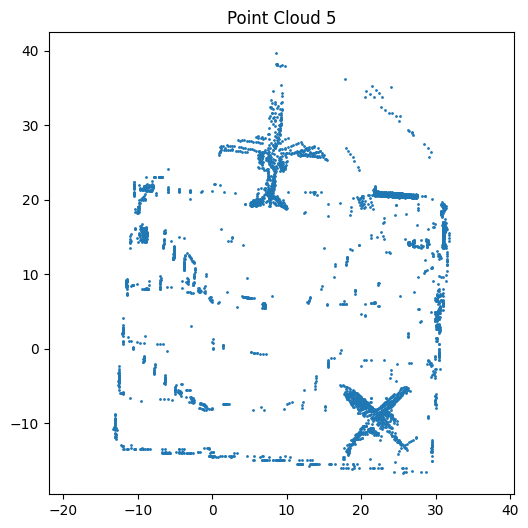


[Frame 5] frame_5.ply
  Tail Point: [ 6.47862904 19.21046646 -2.82449857]


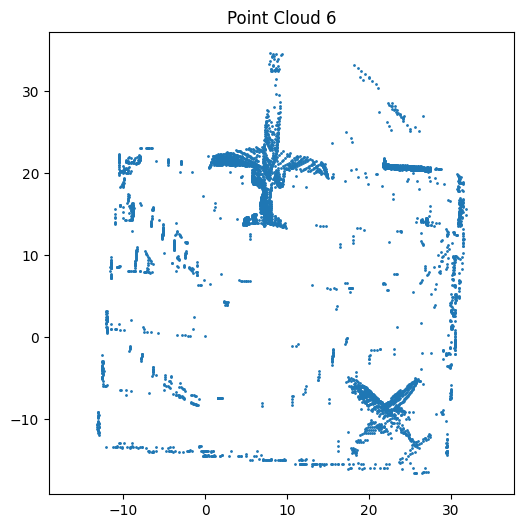


[Frame 6] frame_6.ply
  Tail Point: [ 7.88309207 13.87852504 -3.20862668]


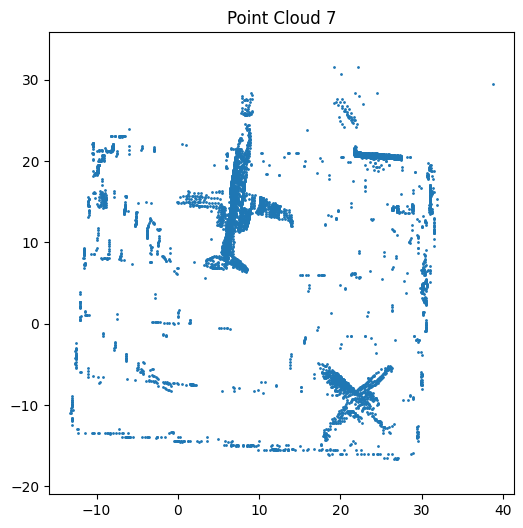


[Frame 7] frame_7.ply
  Tail Point: [ 6.60356471  7.19274957 -4.07086174]


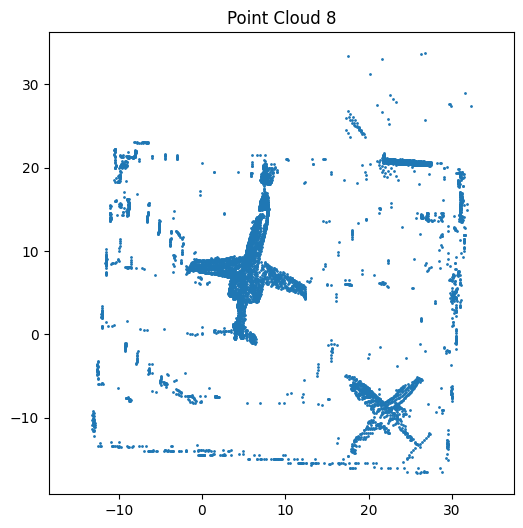


[Frame 8] frame_8.ply
  Tail Point: [ 4.74939638 -0.31339254 -4.45994009]


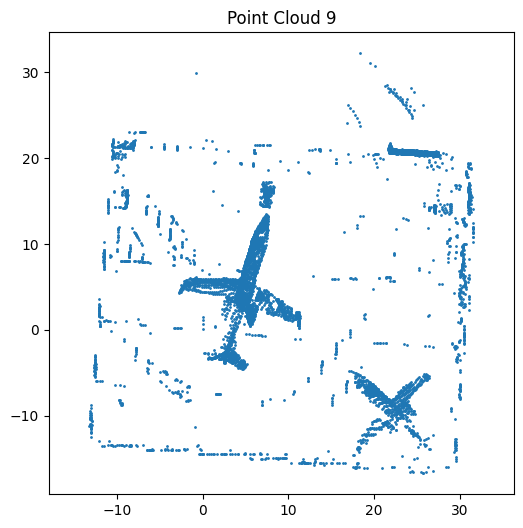


[Frame 9] frame_9.ply
  Tail Point: [ 3.07420167 -3.70375189 -4.69990384]


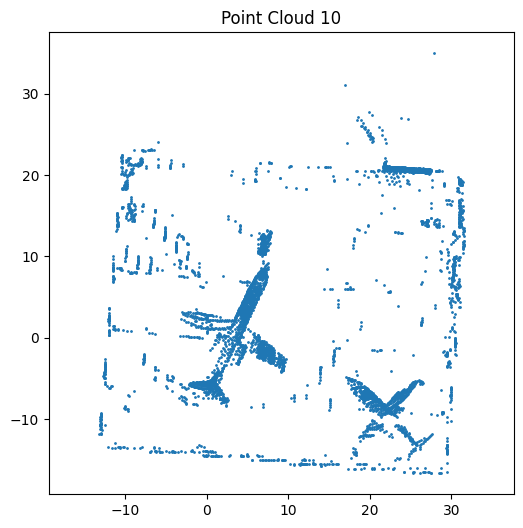


[Frame 10] frame_10.ply
  Tail Point: [-0.10104052 -6.61577218 -4.88577156]


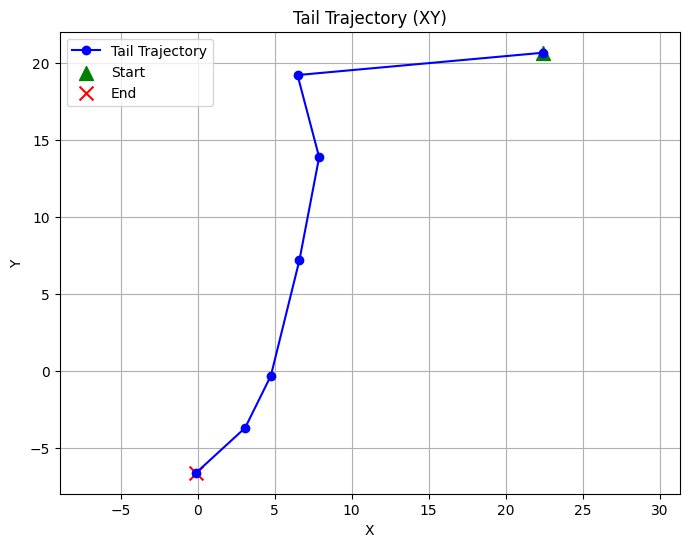

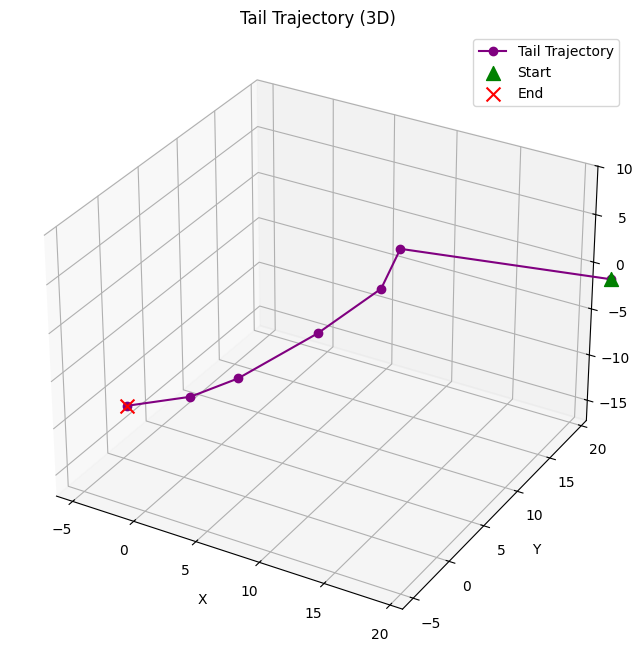

In [3]:
# This cell shows you how to open the pointcloud and iterate through each. 
# You will call your functions within this loop


#----------------Do not change this cell----------------#
VIEW = 'matplotlib'  # Change to 'open3d' for Open3D visualization

base_path =  os.getcwd() + '/data/'

prev_axis = None
tracking_points = []

ply_files = []
for i in range(1,11):
    ply_files.extend(glob.glob(f"{base_path}frame_{i}.ply"))

base_cloud = o3d.geometry.PointCloud()
for i, file in enumerate(ply_files):
    try:
        pcd = o3d.io.read_point_cloud(file)
        
        if VIEW == 'open3d':
            # Visualize the point cloud with Open3D
            o3d.visualization.draw_geometries([pcd])
        elif VIEW == 'matplotlib':
            # Visualize the point cloud with Matplotlib
            points = np.asarray(pcd.points)
            plt.figure(figsize=(6, 6))
            plt.scatter(points[:, 0], points[:, 1], s=1)
            plt.title(f"Point Cloud {i+1}")
            plt.axis('equal')
            plt.show()

        ### CALL YOUR FUNCTION(S) HERE ### 
        print(f"\n[Frame {i+1}] {os.path.basename(file)}")
        if len(np.asarray(pcd.points)) == 0:
            print("  Empty point cloud.")
            continue
            
        pcd = preprocess_point_cloud(pcd)
        clustered = cluster_point_cloud(pcd)

        if clustered is None:
            print("  No airplane cluster detected.")
            continue

        tail_point, centroid, orientation, prev_axis = extract_tracking_point(clustered, prev_axis)

        if tail_point is not None:
            print(f"  Tail Point: {tail_point}")
            tracking_points.append(tail_point)
        else:
            print("  Tail point not found.")
    
    except Exception as e:
        print(f"Failed to read {file}: {e}")
            
if tracking_points:
    plot_tail_trajectory(tracking_points)
else:
    print("No tail points collected.")




** The initial point is the cluster from the wall like structure **

# Follow up Questions:
1. What changes would you make to make this system run real-time? 

    * Restrict the clustering and tracking to a region of interest around the last know location of the aeroplane, to reduce computation 
    * Use more efficient and faster clustering methods than DBSCAN (Euclidean Clustering with KD-tree or Grid Based Clustering )
    * If latency is critical then skipping to every Nth frame adaptively based on current computational load can be implemented


2. Write the advantages and disadvantages of your approach

    - Advantages are :
        *  The solution is purely geometric, so it can be applied to another set of data without major changes
        *  The approach is interpretable and modular, allowing each step (filtering, clustering, PCA) to be debugged and improved independently. 

    - Disadvantages are :
        - Right now I have tuned the parameters for this case, these parameters might or might not work in different scenarios. The only way to ensure this reproduces repeated results is through testing
        - I have implemented a function (is_airplane_like), which computes the bounding box dimensions and checks if the object is long, flat and wide. The scenario was such that this worked out for this particular aircraft. What if there was a smaller aircraft ? Such things can only be verified based on data from various scenarios
        - I chose the vertical stabilizer of the aircraft as the tracking point as I found that the region was very well visible in the point cloud data constantly across all the frames and in this scenario as that part was the first to enter the hangar space, tracking a point using that portion was a safe bet.
        - Clustering and PCA might be slow to use for real time without optimization 

3. How would you extend your approach to account for orientation? 

    - One of the ways would be to compute the centroid and the principle axis using Principle Component Analysis, the centroid will provide the position and the principle axis gives the orientation. 
    - Another way would be to project the 3D point cloud to a 2D plane and use Hu moments to compute pose, which gives pose in Top-Down view.



2. 
    - Advantages are :
        *  The solution is purely geometric, so it can be applied to another set of data without major changes
        *  The approach is interpretable and modular, allowing each step (filtering, clustering, PCA) to be debugged and improved independently. 

    - Disadvantages are :
        - Right now I have tuned the parameters for this case, these parameters might or might not work in different scenarios. The only way to ensure this reproduces repeated results is through testing
        - I have implemented a function (is_airplane_like), which computes the bounding box dimensions and checks if the object is long, flat and wide. The scenario was such that this worked out for this particular aircraft. What if there was a smaller aircraft ? Such things can only be verified based on data from various scenarios
        - I chose the vertical stabilizer of the aircraft as the tracking point as I found that the region was very well visible in the point cloud data constantly across all the frames and in this scenario as that part was the first to enter the hangar space, tracking a point using that portion was a safe bet.
        - Clustering and PCA might be slow to use for real time without optimization 

3. One of the ways would be to compute the centroid and the principle axis using Principle Component Analysis, the centroid will provide the position and the principle axis gives the orientation. 

# Collision Detection
**For this section, you should NOT write any code.**

Outline an algorithm for detecting potential collisions with the tracked aircraft within a specific margin. For instance, if this margin is 1ft, you should only return objects that are within 1ft of the aircraft. Things to think about
- How would you handle cases where the aircraft is partially or fully occluded?
- How might the presence of people or other dynamic obstacles affect your approach?
- How would you handle both static and dynamic objects in the environment?
- How would you ensure the algorithm is capable of real-time performance?
- In order for collision detection to work well, it should account for the fact that airplane wings can overlap.

Inputs:
- Tracked pose of aircraft (x,y,z,roll,pitch,yaw)
- Segmented Aircraft (points)

Outputs:
- Array of collision points within specific margin.

- Occulsion Handling : 
    * Using the same method, i.e., fusing data from 4 LiDAR sensors, the missing regions can be filled in using prior static map data or last know positions. 

- Handling People or Dynamic Obstacles: 
    * We can segment the incoming point cloud into static and dynamic classes using clustering, motion history, or semantic labels. Dynamic entities such as humans or vehicles can be tracked frame to frame. For safety critical operations, these are prioritized in collision detection and flagged even if only partially within the defined margin.

- Static and Dynamic Obstacles : 
    * Static obstacles (parked planes, walls, pillars) are incorporated using both live LiDAR and pre built static maps.
    * Dynamic obstacles (personnel/ service vehicles) are updated in real time and handled using temporal tracking or prediction if temporarily occluded.
    * Both are evaluated against the aircraft's geometry with margin buffers. 

- Real-time performance : 
    * Since the LiDAR data is a feature intensive data, we can downsample the data to reduce density (ensure that the feature information is rich enough to perform the required tasks)
    * Only consider the points present at a certain radius / offset near the moving aircraft to reduce computational load

- Accounting for overlapping wings : 
    * Under the assumption that only one aircraft will be moving, the static map can be leveraged and the moving aircraft can be segmented and we can use 3D Euclidean distances to confirm whether the proximity actually violates the defined collision margin
    * Only the wings can be segmented seperately and spacing efficiency can be improved and margins can be set for improving the spacing efficiency. 

# Write Pseudo Code Here

function detect_collisions(pose, point_cloud, margin):
    # Step 1: Predict unseen areas using map if occluded
    if occlusion_detected(pose, point_cloud):
        point_cloud += get_map_based_occluded_points(pose)

    # Step 2: Filter static vs dynamic (if labeled)
    static_obstacles = filter_static(point_cloud)
    dynamic_obstacles = filter_dynamic(point_cloud)
    all_obstacles = static_obstacles + dynamic_obstacles

    # Step 3: Create bounding volumes around aircraft with margin
    aircraft_boxes = get_aircraft_bounding_boxes(pose, margin)

    # Step 4: Filter points within bounding region (broad phase)
    candidate_points = spatial_filter(all_obstacles, aircraft_boxes)

    # Step 5: Check each point for collision (narrow phase)
    collision_points = []
    for point in candidate_points:
        if any(box.contains(point) for box in aircraft_boxes):
            collision_points.append(point)

    return collision_points


Airplane Detection 
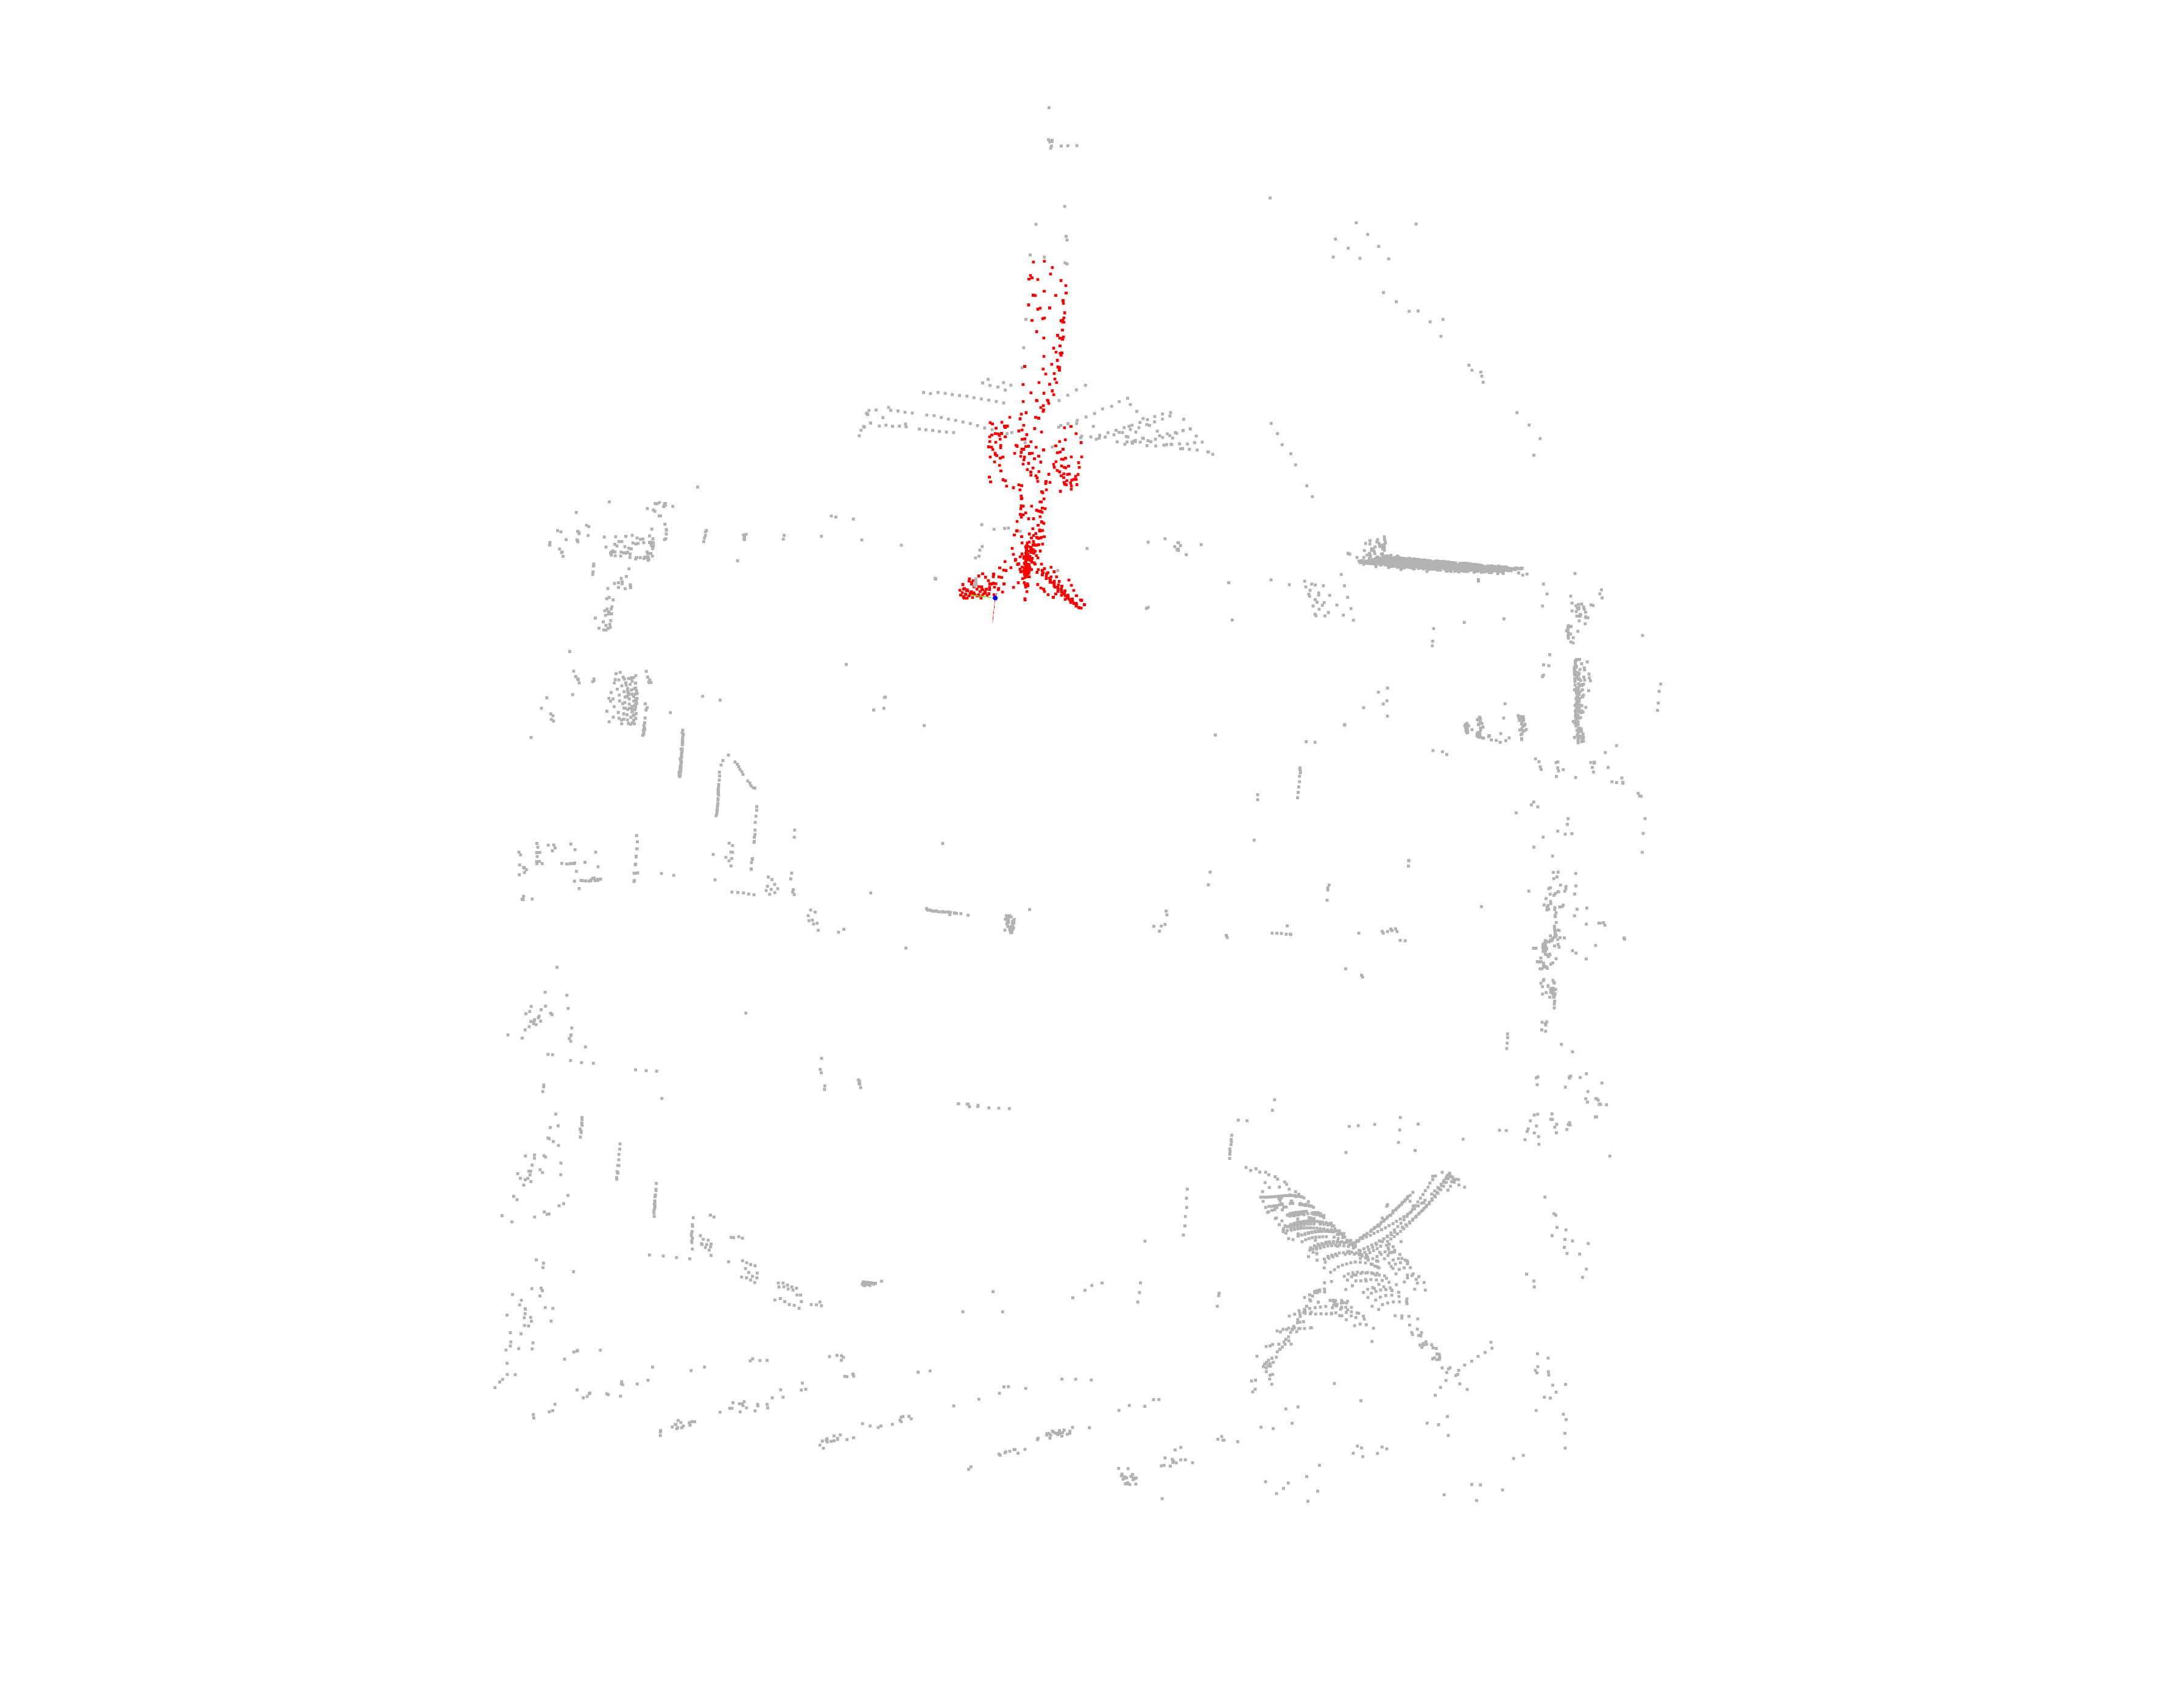
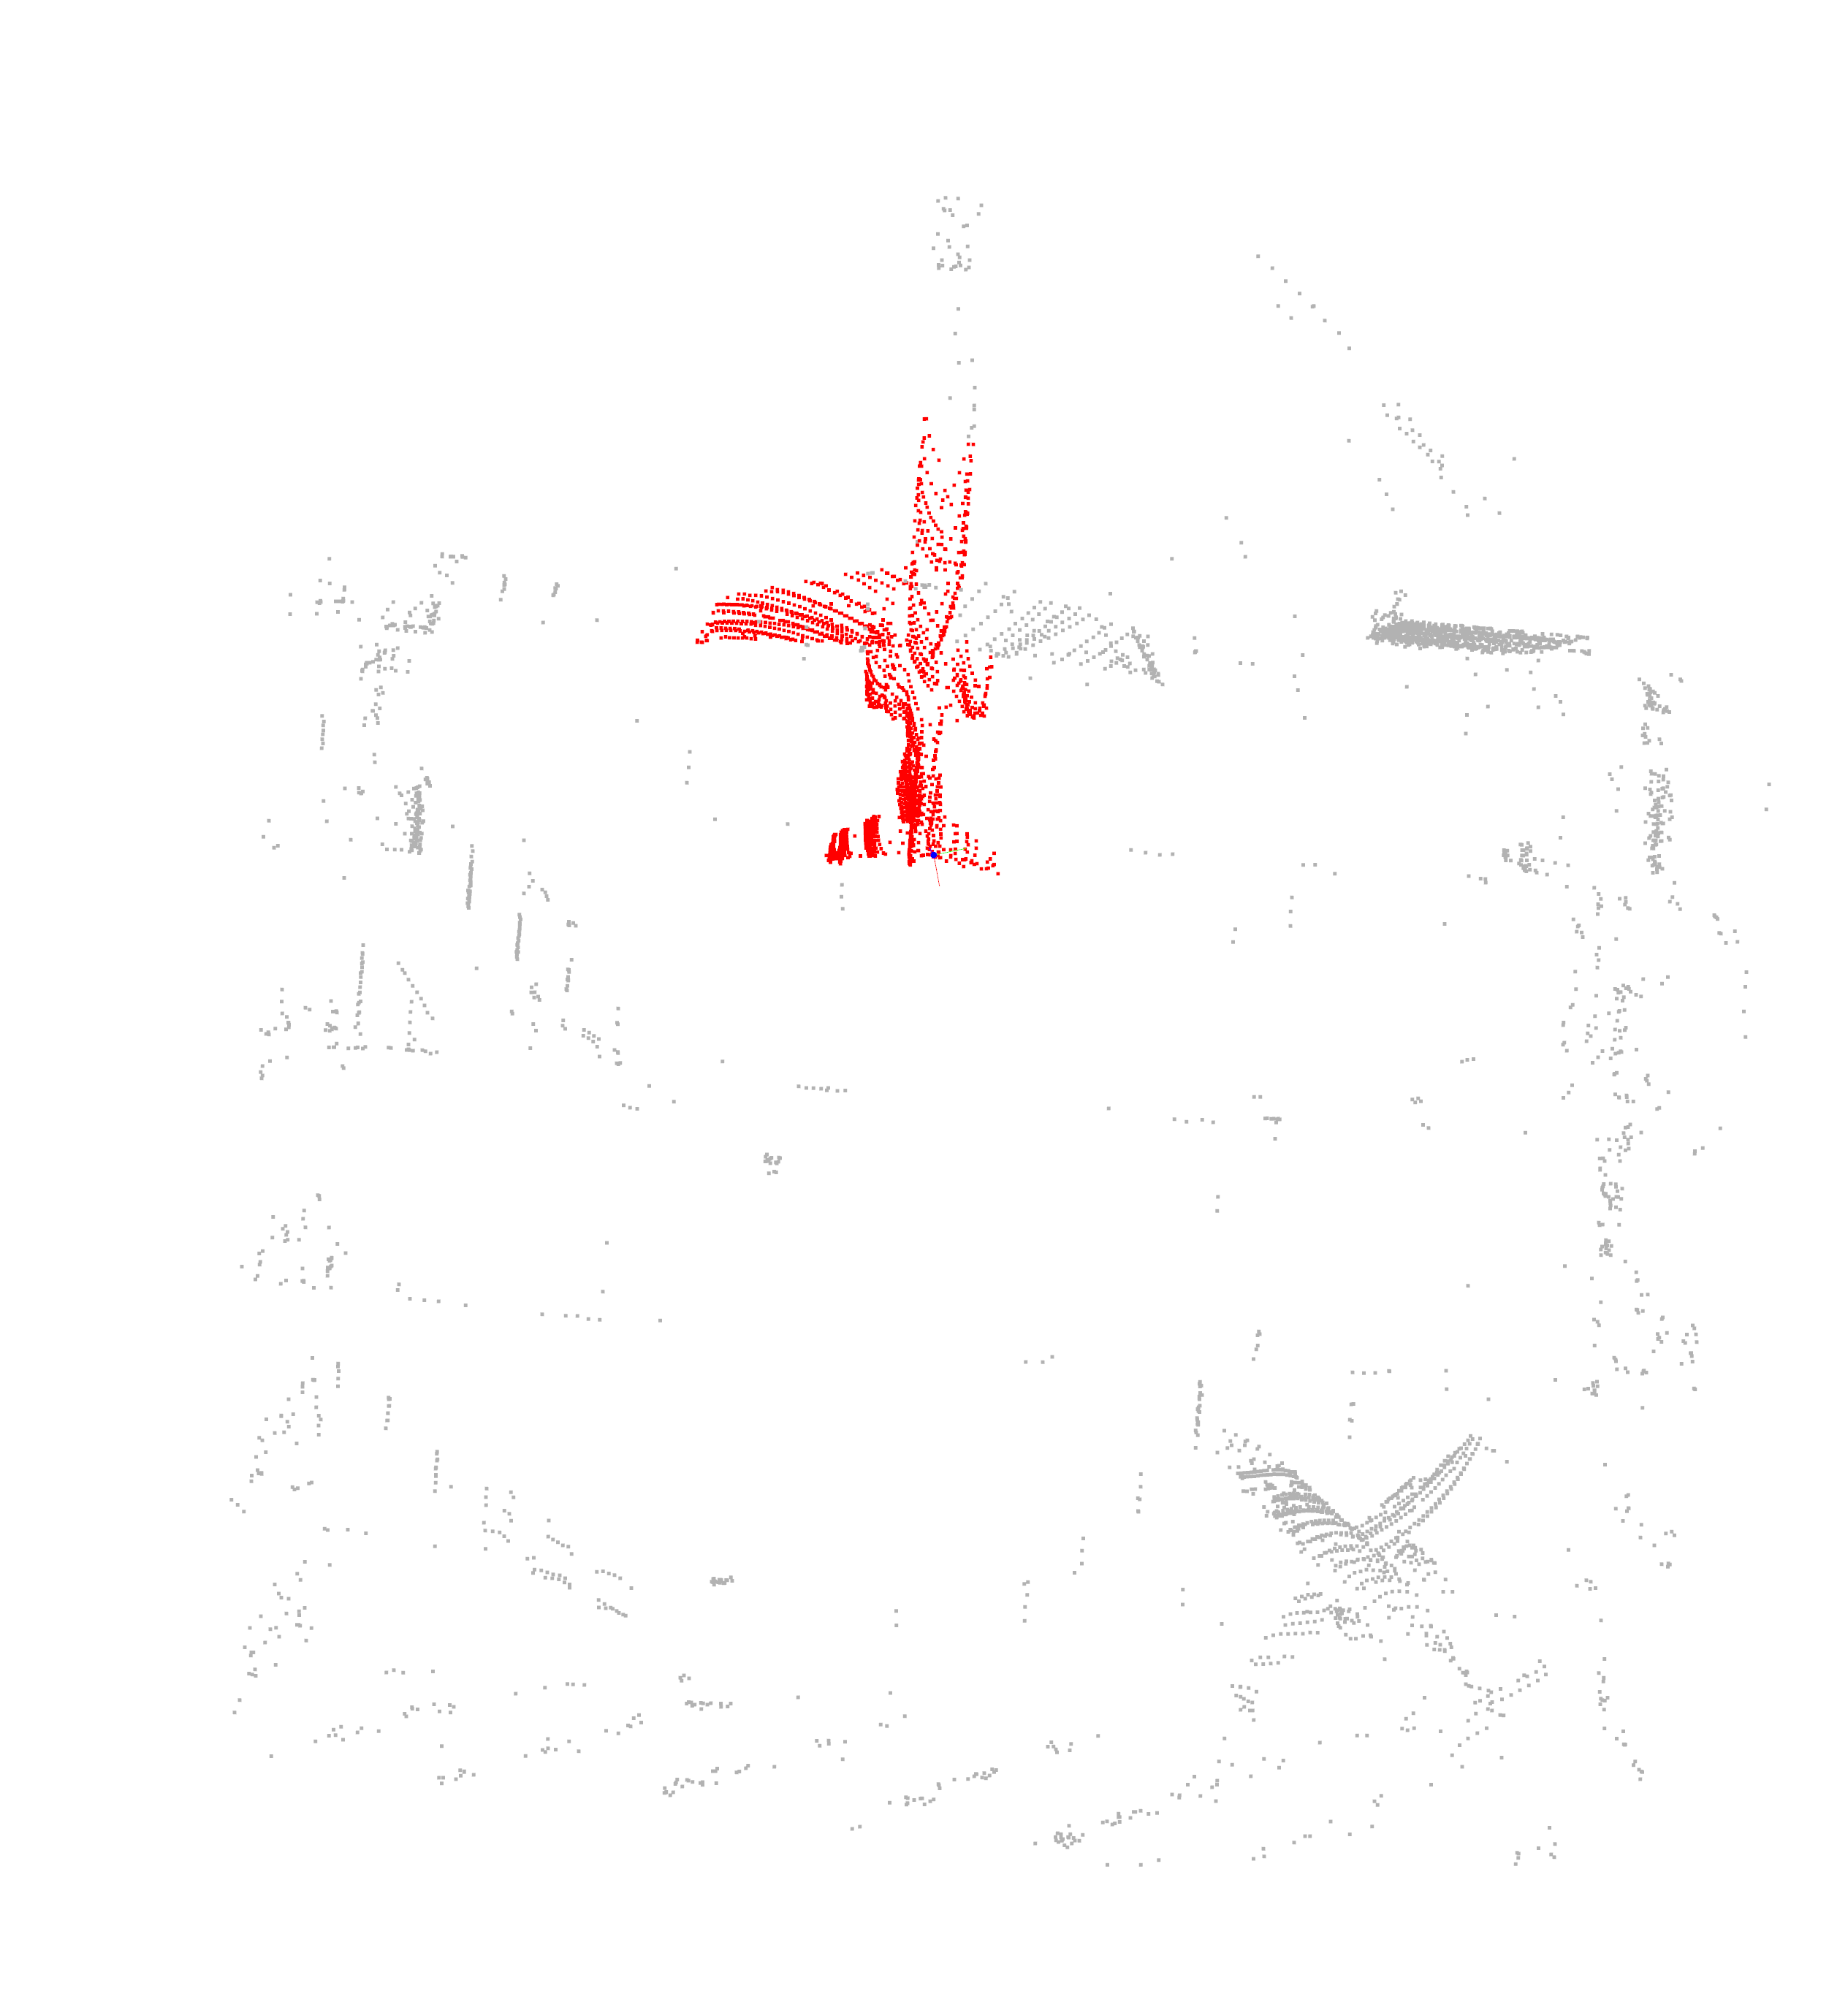
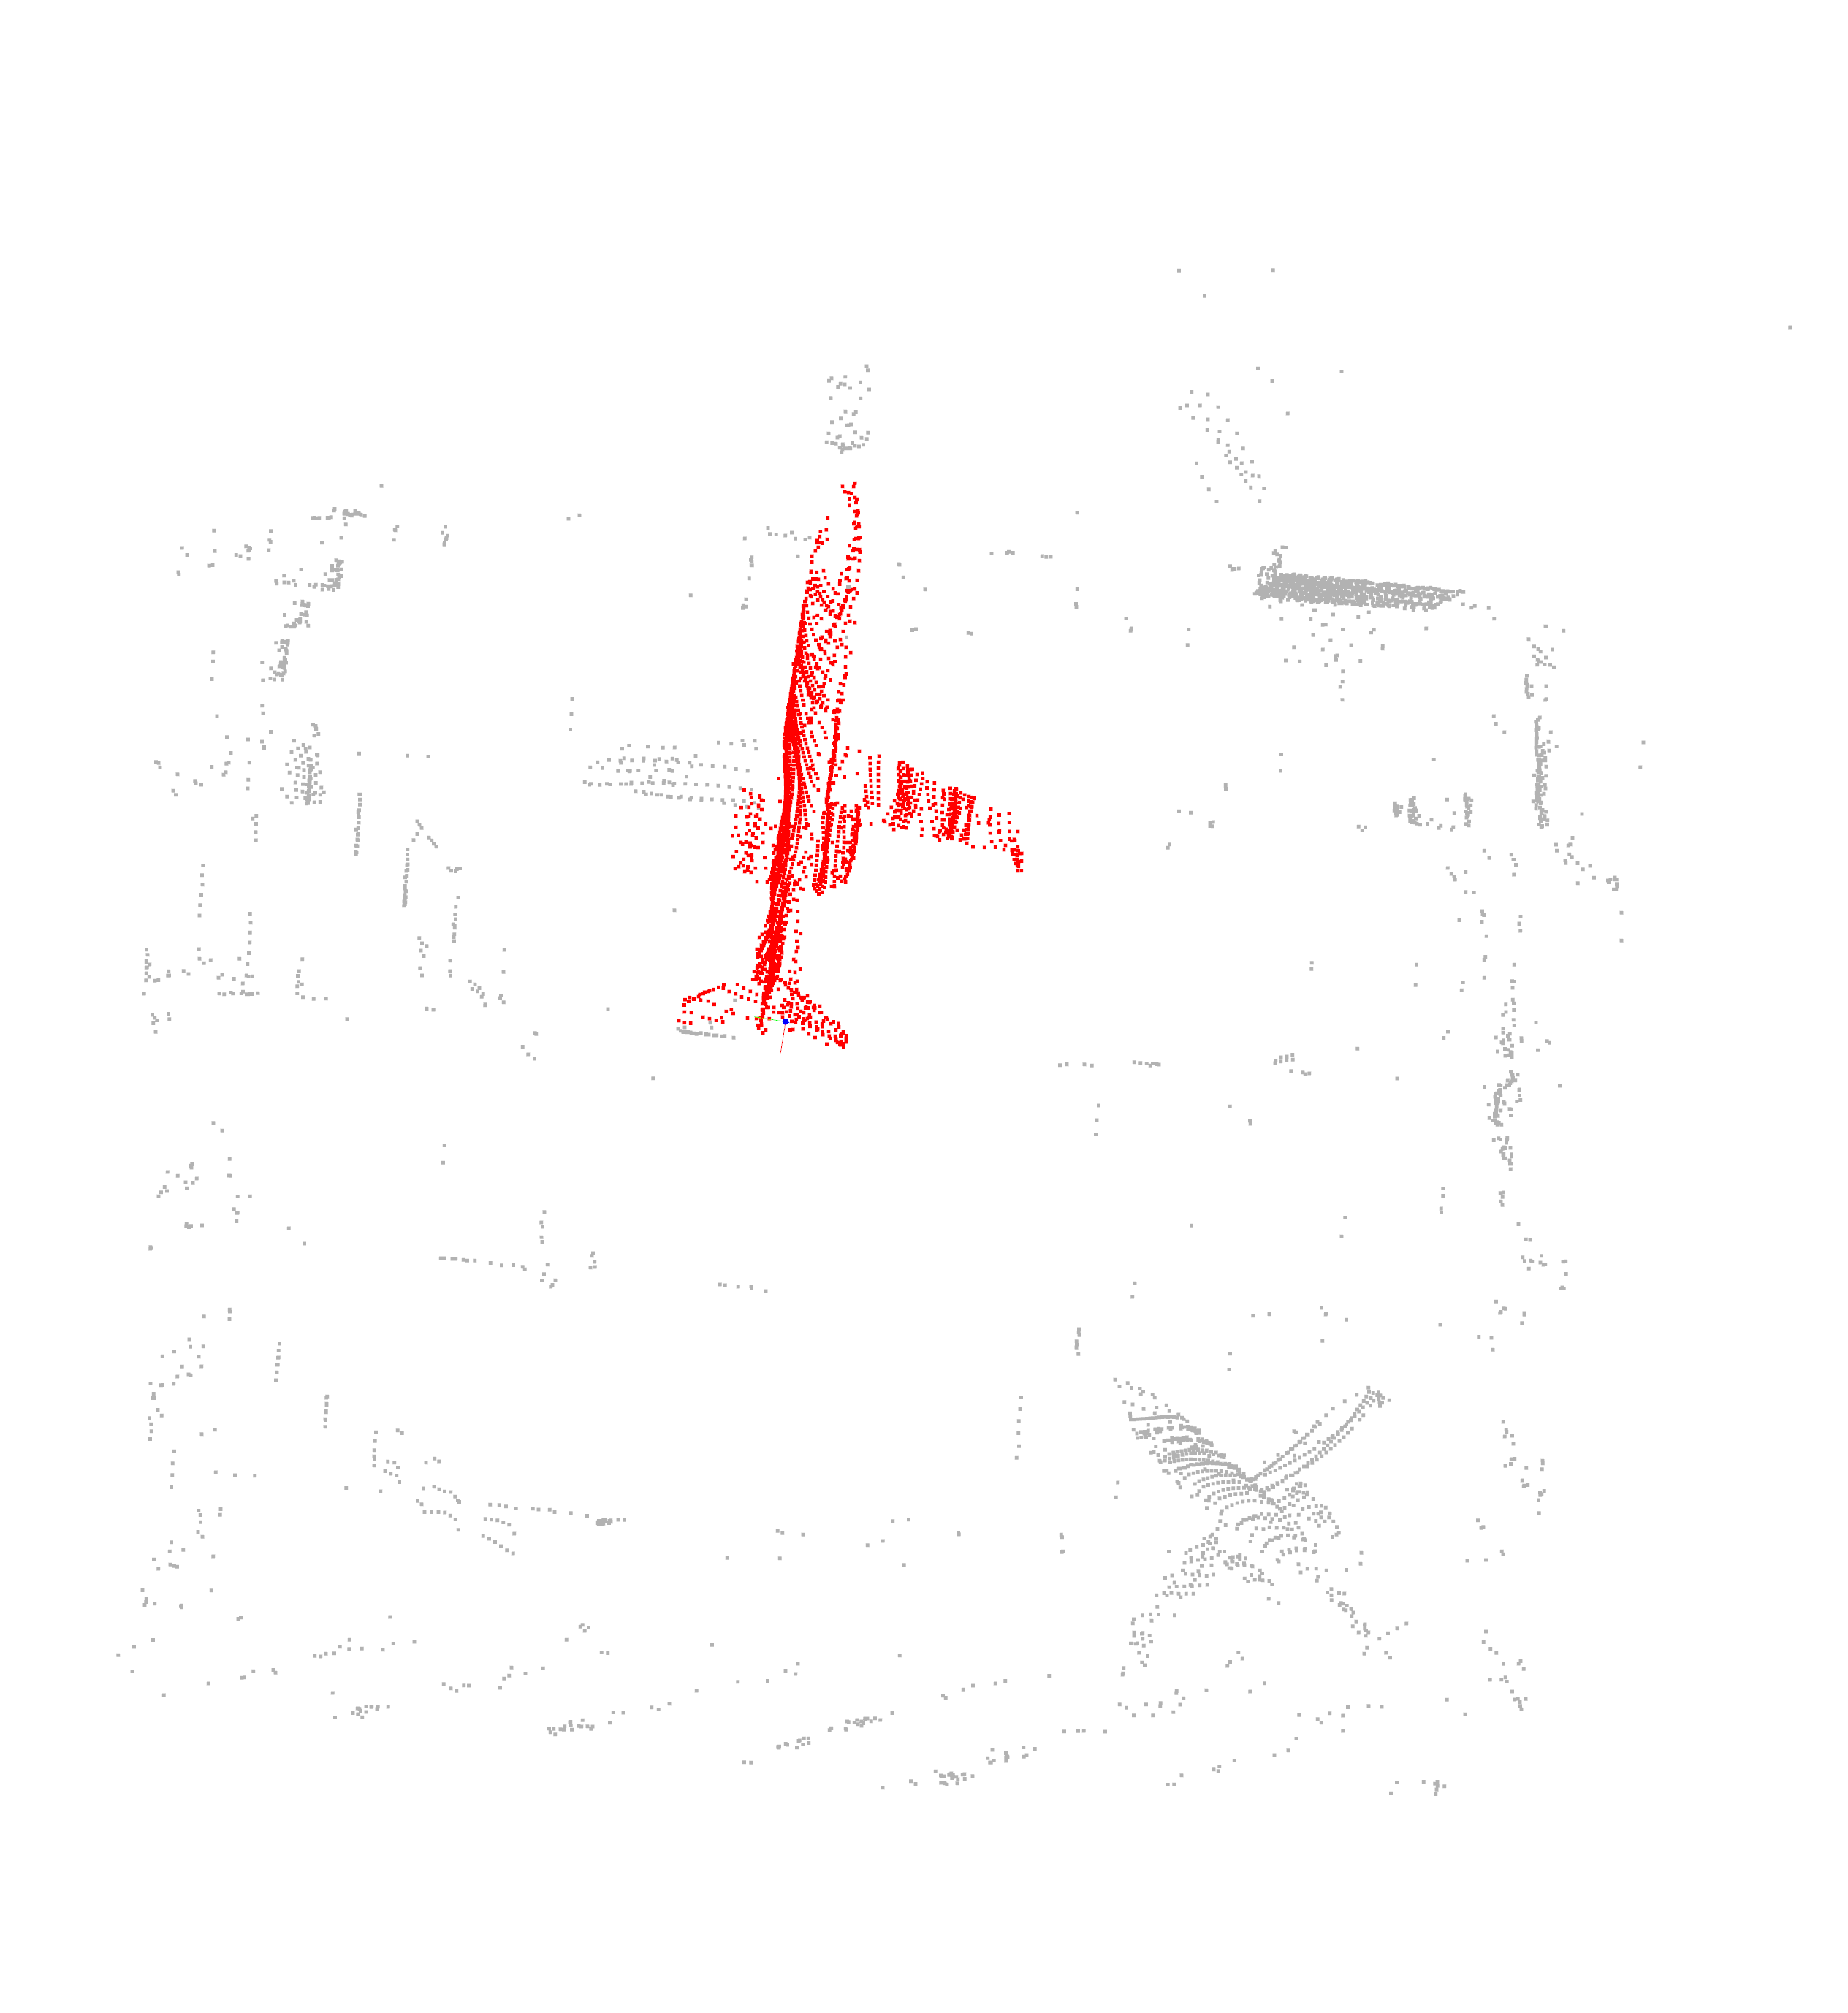
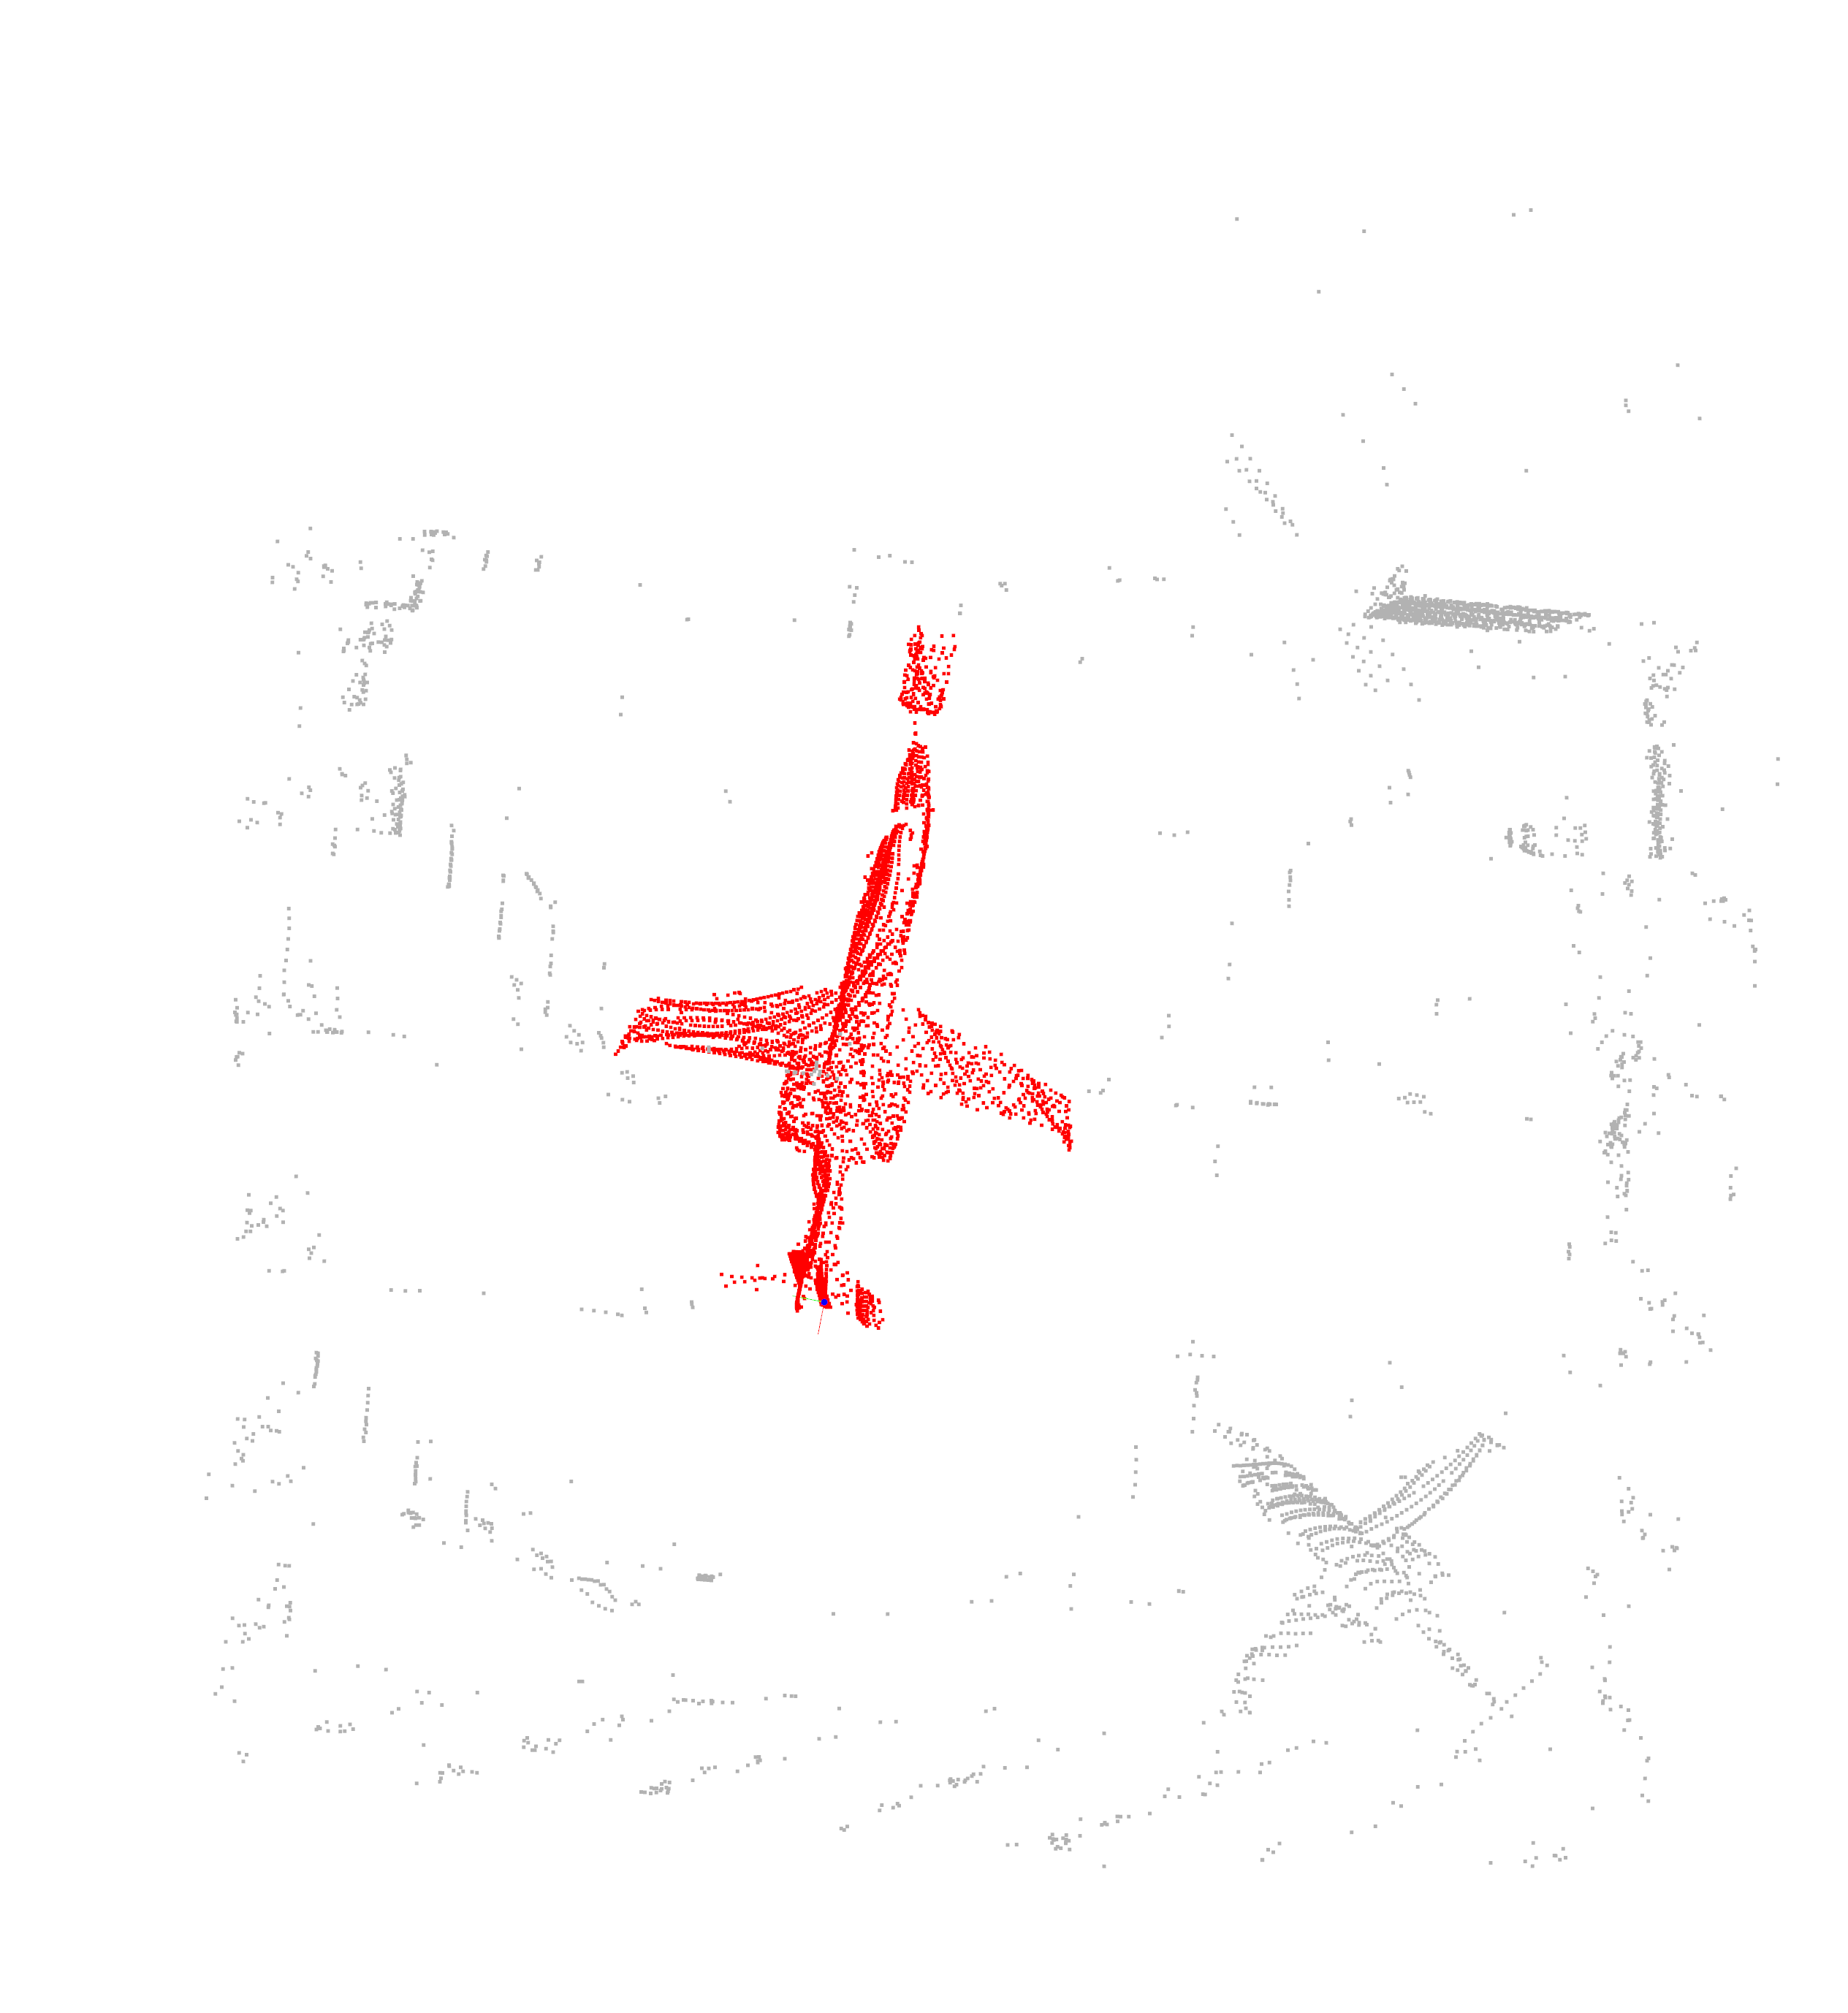
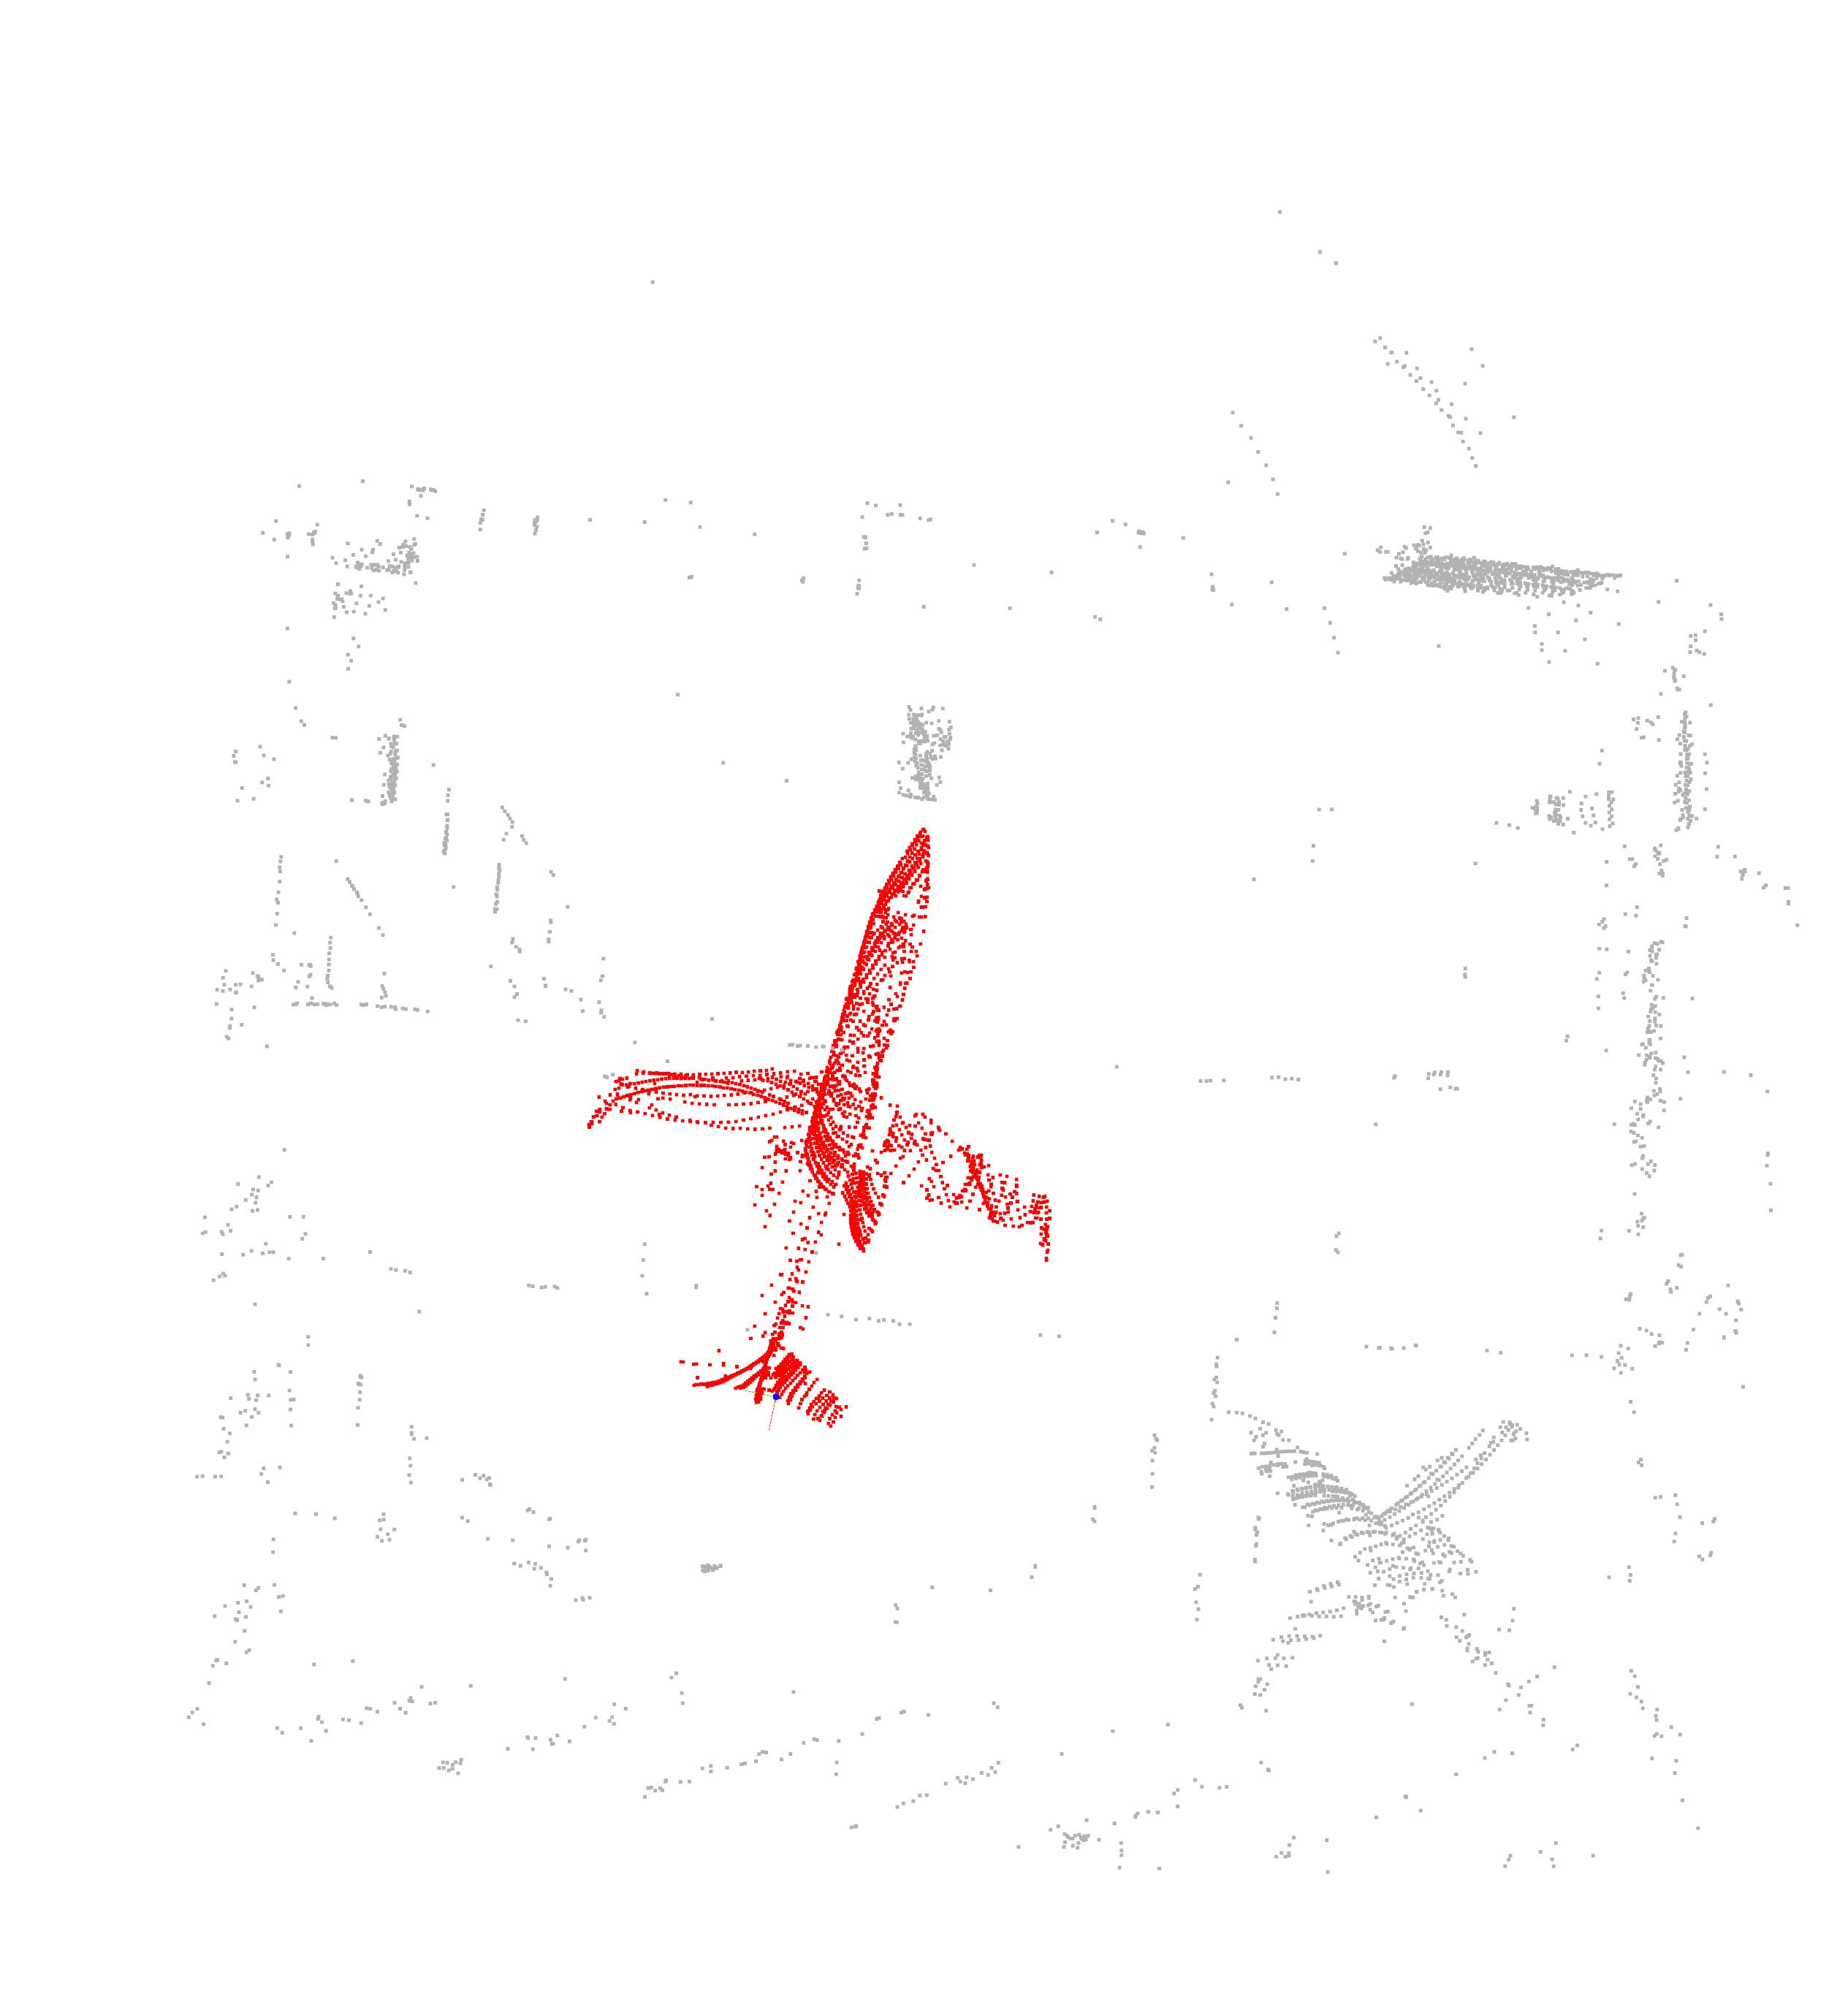
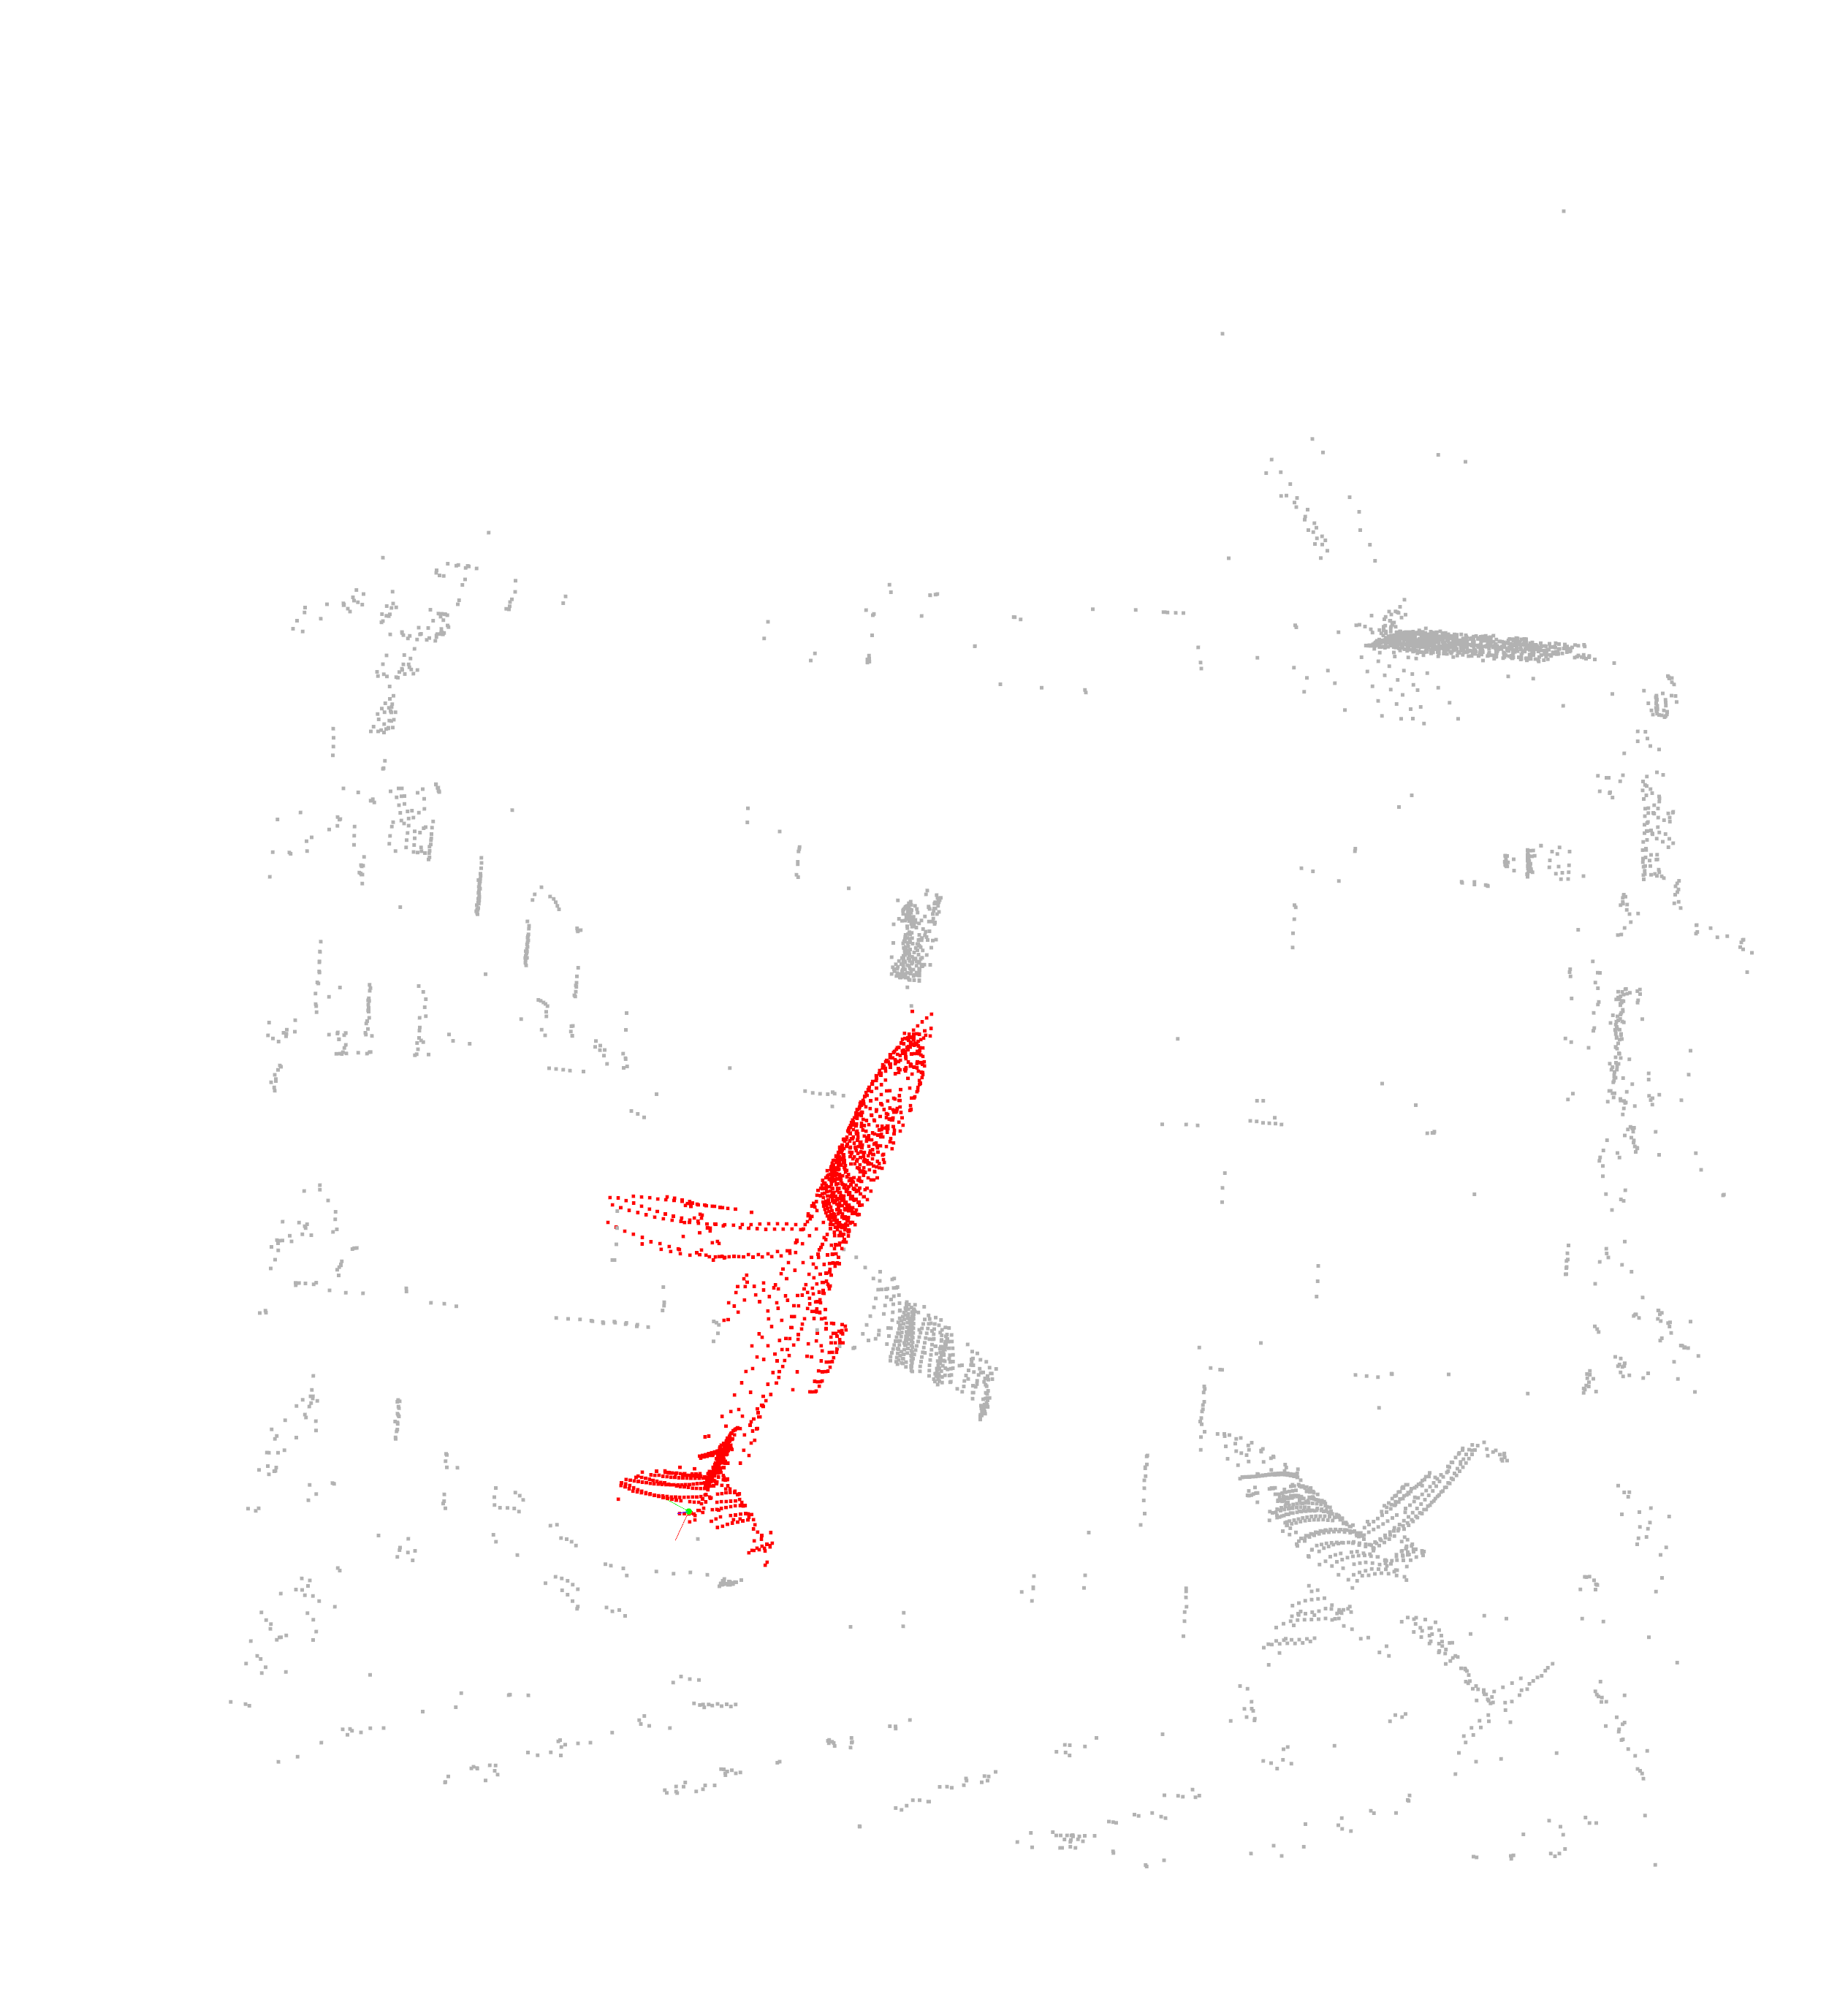
